In [9]:
### Import libraries

import igraph as ig
import numpy as np
import os
from collections import Counter, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_opti_two import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [10]:
### Select dataset
DATASET = "amz" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Load Dataset

In [11]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079

The graph IS bipartite


In [27]:
NODETYPE = 0   # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
#bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics = {'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426, 'x15': gb.density(), 'x16': statistics.mean(gb.degree(gb.vs.select(type=0)))}

bip_metrics

{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426,
 'x15': 0.00022469516962160804,
 'x16': 3.427361154690932}

In [28]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
#a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 40


In [29]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

#analizar_frente(counter_sols, DATASET.upper()+" Top")


Frente 1 (6 soluciones):
hyper_DF_a1
resall_DF_a15
resall_DF_a1
hyper_DF_a05
resall_NC_a1
resall_DF_a05

Frente 2 (9 soluciones):
resall_NC_a15
hyper_DF_a15
hyper_DF_a2
vector_DF_a15
jaccard_DF_a1
resall_DF_a2
hyper_NC_a2
vector_DF_a2
jaccard_DF_a15

Frente 3 (6 soluciones):
neighs_DF_a15
resall_NC_a05
hyper_NC_a15
resall_NC_a2
neighs_DF_a2
jaccard_DF_a2

Frente 4 (2 soluciones):
neighs_NC_a15
neighs_DF_a1

Frente 5 (9 soluciones):
simple_NC_a05
hyper_NC_a1
vector_NC_a15
neighs_NC_a05
hyper_NC_a05
simple_NC_a1
vector_NC_a05
neighs_NC_a2
vector_NC_a1

Frente 6 (3 soluciones):
jaccard_NC_a05
vector_NC_a2
neighs_NC_a1

Frente 7 (3 soluciones):
simple_NC_a15
jaccard_NC_a15
jaccard_NC_a1

Frente 8 (2 soluciones):
jaccard_NC_a2
simple_NC_a2


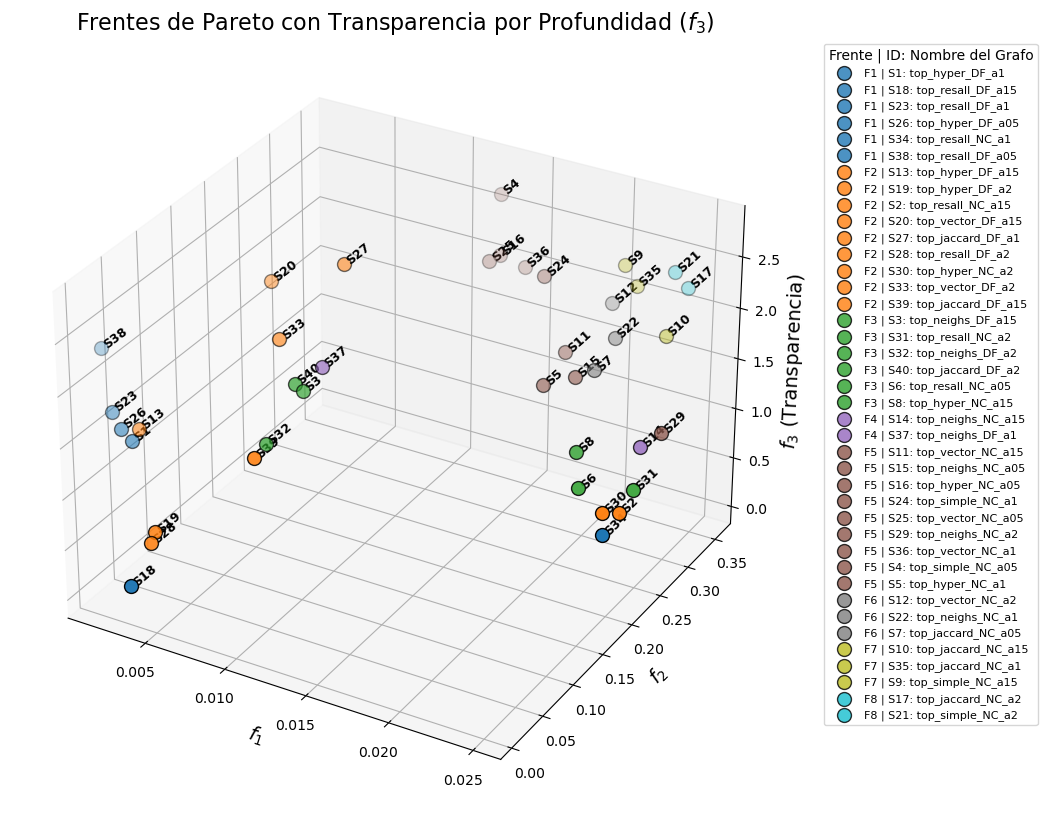

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D 

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'f3', 'name'. 
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y ASIGNACIÓN DE RANKS (Sin cambios) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        rank_map[sol["filename"]] = rank

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 

plot_DF = final_DF[final_DF['rank'] > 0].copy()
plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str) 
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'][4:]}", 
    axis=1
)

# --- 2. CÁLCULO DE TRANSPARENCIA (NUEVO) ---

# Normalizar f3 entre 0 y 1
f3_min = plot_DF['f3'].min()
f3_max = plot_DF['f3'].max()

# Calcular la transparencia: La opacidad es inversamente proporcional a f3.
# Si f3 es bajo (bueno), opacidad es alta (cerca de 1.0).
# Si f3 es alto (malo), opacidad es baja (cerca de 0.2, el mínimo).
# Usamos un rango de 0.2 a 1.0 para que ningún punto desaparezca totalmente.
ALPHA_MIN = 0.2
ALPHA_MAX = 1.0

if f3_max > f3_min:
    # Mapear f3_normalized (0 para max, 1 para min) al rango de ALPHA_MIN a ALPHA_MAX
    plot_DF['f3_norm'] = (f3_max - plot_DF['f3']) / (f3_max - f3_min)
    plot_DF['alpha_val'] = ALPHA_MIN + plot_DF['f3_norm'] * (ALPHA_MAX - ALPHA_MIN)
else:
    # Si todos los f3 son iguales, la transparencia es máxima
    plot_DF['alpha_val'] = ALPHA_MAX

# --- 3. GENERAR LA GRÁFICA CON MATPLOTLIB ---

fig = plt.figure(figsize=(14, 10)) 
ax = fig.add_subplot(111, projection='3d') 

unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)

if num_unique_ranks <= 10:
    cmap = cm.get_cmap('tab10', num_unique_ranks)
else:
    cmap = cm.get_cmap('tab20', num_unique_ranks)

# 3a. Graficar los puntos por FRENTE 
# NOTA: Para aplicar transparencia individual, no podemos usar la función ax.scatter una vez por frente.
# Debemos iterar por punto y garantizar que el color sea el mismo para el frente.

# Diccionario para almacenar el color fijo de cada frente para la leyenda
rank_color_map = {r: cmap(r - 1) for r in unique_ranks}

# Diccionario para almacenar handles de la leyenda
legend_data = {}

for index, row in plot_DF.iterrows():
    
    rank_int = row['rank']
    color = rank_color_map[rank_int]
    
    # 1. Graficar en 3D: Usamos el alpha calculado individualmente (row['alpha_val'])
    ax.scatter(
        row['f1'],
        row['f2'],
        row['f3'],  
        s=100,             
        alpha=row['alpha_val'], # <--- Usamos el valor individual de transparencia
        edgecolors='black',
        color=color # Color fijo por frente
    )
    
    # Almacenamos handles y etiquetas para la leyenda detallada
    # Solo necesitamos los datos una vez por solución (no por frente)
    legend_data[row['ID']] = {
        'color': color, 
        'label': row['legend_label'], 
        'f1': row['f1'], 'f2': row['f2'], 'f3': row['f3'],
        'ID': row['ID']
    }

# 3b. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    ax.text(
        row['f1'], 
        row['f2'], 
        row['f3'],       
        row['ID'],       
        fontsize=9,
        weight='bold',
        zdir='y',        
        color='black'
    )

# 3c. Crear la Leyenda detallada (Objetos Proxy)
legend_handles = []
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    
    # Proxy para la leyenda: El alpha es fijo aquí, solo importa el color
    proxy = plt.scatter([], [], 
                        c=[data['color']], 
                        label=data['label'], 
                        s=100, edgecolors='black',
                        alpha=0.8) # Alpha fijo para la leyenda
    legend_handles.append(proxy)


# 3d. Finalizar el Gráfico (Etiquetas 3D)
ax.set_title('Frentes de Pareto con Transparencia por Profundidad ($f_3$)', fontsize=16)
ax.set_xlabel('$f_1$', fontsize=14)
ax.set_ylabel('$f_2$', fontsize=14)
ax.set_zlabel('$f_3$ (Transparencia)', fontsize=14) 

# Mover el recuadro del legend más a la derecha
ax.legend(handles=legend_handles, 
           title="Frente | ID: Nombre del Grafo", 
           loc='upper left', 
           bbox_to_anchor=(1.05, 1), 
           fontsize=8)

plt.show()

Matriz de correlación:
          f1        f2        f3
f1  1.000000  0.570105  0.107438
f2  0.570105  1.000000  0.279059
f3  0.107438  0.279059  1.000000


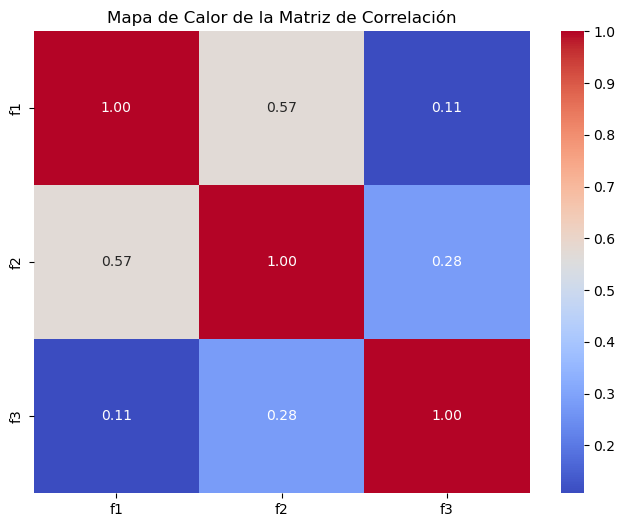

In [16]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-2]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [23]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
#bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics = {'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426, 'x15': gb.density(), 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426,
 'x15': 0.00022469516962160804,
 'x16': 4.358739026336791}

In [24]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 32


In [25]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)



Frente 1 (5 soluciones):
vector_DF_a15
jaccard_DF_a2
neighs_DF_a1
vector_DF_a1
jaccard_DF_a15

Frente 2 (6 soluciones):
hyper_NC_a05
vector_DF_a2
simple_NC_a05
neighs_DF_a2
resall_NC_a05
neighs_DF_a15

Frente 3 (8 soluciones):
hyper_NC_a15
jaccard_NC_a05
resall_NC_a1
hyper_NC_a1
simple_NC_a15
jaccard_NC_a1
resall_NC_a15
simple_NC_a1

Frente 4 (4 soluciones):
jaccard_NC_a15
hyper_NC_a2
jaccard_NC_a2
resall_NC_a2

Frente 5 (3 soluciones):
simple_NC_a2
neighs_NC_a1
vector_NC_a05

Frente 6 (3 soluciones):
neighs_NC_a05
neighs_NC_a15
vector_NC_a1

Frente 7 (2 soluciones):
vector_NC_a15
neighs_NC_a2

Frente 8 (1 soluciones):
vector_NC_a2


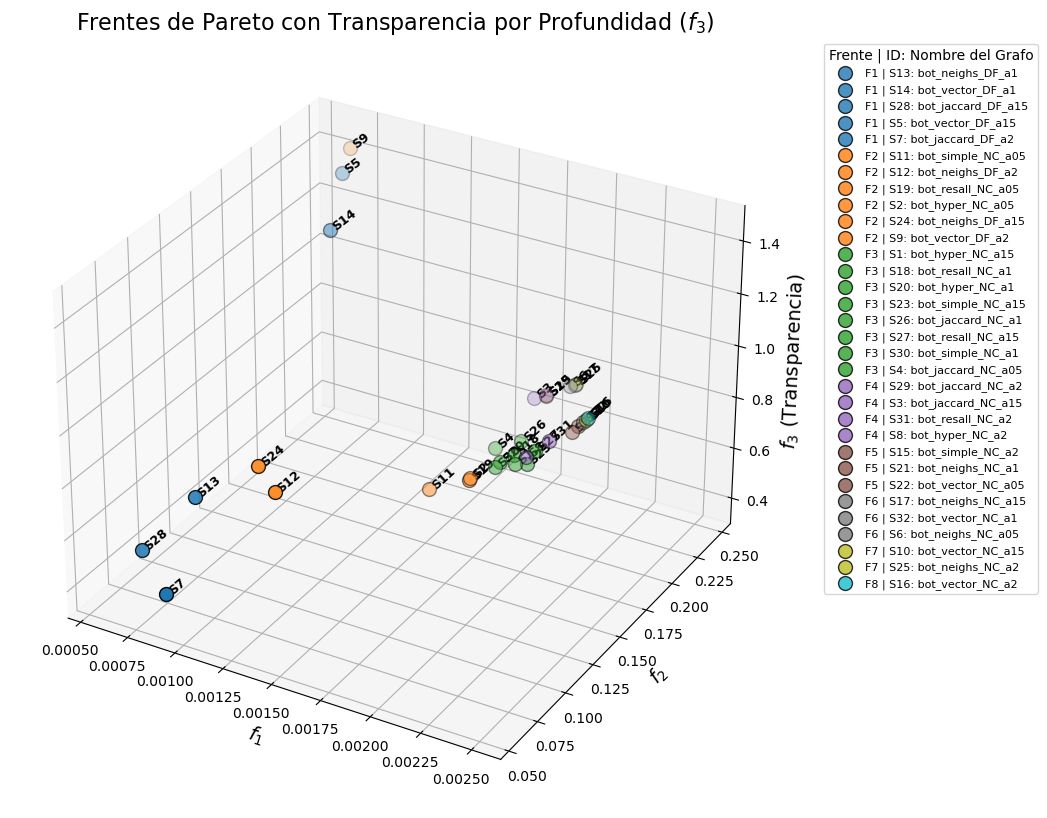

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D 

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'f3', 'name'. 
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y ASIGNACIÓN DE RANKS (Sin cambios) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        rank_map[sol["filename"]] = rank

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 

plot_DF = final_DF[final_DF['rank'] > 0].copy()
plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str) 
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'][4:]}", 
    axis=1
)

# --- 2. CÁLCULO DE TRANSPARENCIA (NUEVO) ---

# Normalizar f3 entre 0 y 1
f3_min = plot_DF['f3'].min()
f3_max = plot_DF['f3'].max()

# Calcular la transparencia: La opacidad es inversamente proporcional a f3.
# Si f3 es bajo (bueno), opacidad es alta (cerca de 1.0).
# Si f3 es alto (malo), opacidad es baja (cerca de 0.2, el mínimo).
# Usamos un rango de 0.2 a 1.0 para que ningún punto desaparezca totalmente.
ALPHA_MIN = 0.2
ALPHA_MAX = 1.0

if f3_max > f3_min:
    # Mapear f3_normalized (0 para max, 1 para min) al rango de ALPHA_MIN a ALPHA_MAX
    plot_DF['f3_norm'] = (f3_max - plot_DF['f3']) / (f3_max - f3_min)
    plot_DF['alpha_val'] = ALPHA_MIN + plot_DF['f3_norm'] * (ALPHA_MAX - ALPHA_MIN)
else:
    # Si todos los f3 son iguales, la transparencia es máxima
    plot_DF['alpha_val'] = ALPHA_MAX

# --- 3. GENERAR LA GRÁFICA CON MATPLOTLIB ---

fig = plt.figure(figsize=(14, 10)) 
ax = fig.add_subplot(111, projection='3d') 

unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)

if num_unique_ranks <= 10:
    cmap = cm.get_cmap('tab10', num_unique_ranks)
else:
    cmap = cm.get_cmap('tab20', num_unique_ranks)

# 3a. Graficar los puntos por FRENTE 
# NOTA: Para aplicar transparencia individual, no podemos usar la función ax.scatter una vez por frente.
# Debemos iterar por punto y garantizar que el color sea el mismo para el frente.

# Diccionario para almacenar el color fijo de cada frente para la leyenda
rank_color_map = {r: cmap(r - 1) for r in unique_ranks}

# Diccionario para almacenar handles de la leyenda
legend_data = {}

for index, row in plot_DF.iterrows():
    
    rank_int = row['rank']
    color = rank_color_map[rank_int]
    
    # 1. Graficar en 3D: Usamos el alpha calculado individualmente (row['alpha_val'])
    ax.scatter(
        row['f1'],
        row['f2'],
        row['f3'],  
        s=100,             
        alpha=row['alpha_val'], # <--- Usamos el valor individual de transparencia
        edgecolors='black',
        color=color # Color fijo por frente
    )
    
    # Almacenamos handles y etiquetas para la leyenda detallada
    # Solo necesitamos los datos una vez por solución (no por frente)
    legend_data[row['ID']] = {
        'color': color, 
        'label': row['legend_label'], 
        'f1': row['f1'], 'f2': row['f2'], 'f3': row['f3'],
        'ID': row['ID']
    }

# 3b. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    ax.text(
        row['f1'], 
        row['f2'], 
        row['f3'],       
        row['ID'],       
        fontsize=9,
        weight='bold',
        zdir='y',        
        color='black'
    )

# 3c. Crear la Leyenda detallada (Objetos Proxy)
legend_handles = []
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    
    # Proxy para la leyenda: El alpha es fijo aquí, solo importa el color
    proxy = plt.scatter([], [], 
                        c=[data['color']], 
                        label=data['label'], 
                        s=100, edgecolors='black',
                        alpha=0.8) # Alpha fijo para la leyenda
    legend_handles.append(proxy)


# 3d. Finalizar el Gráfico (Etiquetas 3D)
ax.set_title('Frentes de Pareto con Transparencia por Profundidad ($f_3$)', fontsize=16)
ax.set_xlabel('$f_1$', fontsize=14)
ax.set_ylabel('$f_2$', fontsize=14)
ax.set_zlabel('$f_3$ (Transparencia)', fontsize=14) 

# Mover el recuadro del legend más a la derecha
ax.legend(handles=legend_handles, 
           title="Frente | ID: Nombre del Grafo", 
           loc='upper left', 
           bbox_to_anchor=(1.05, 1), 
           fontsize=8)

plt.show()